In [1]:
## a useful function to generate a data list for further analysis
import os,json,sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import linalg as LA
from scipy import stats
import scipy.stats as st
import h5py
from sorting_time_series_analysis import follow_behaviour_analysis
##need to add this additional cell because useful tools are in another folder. Need to integrate these two folders one day
current_working_directory = Path.cwd()
parent_dir = current_working_directory.resolve().parents[0]
sys.path.insert(0, str(parent_dir) + "\\utilities")
from useful_tools import select_animals_gpt,find_file
from data_cleaning import findLongestConseqSubseq

In [2]:
json_file = "./analysis_methods_dictionary.json"
with open(json_file, "r") as f:
    analysis_methods = json.loads(f.read())
    
#Put the folder of your Unity folder below
#thisDataset ="D:/MatrexVR_Swarm_Data/RunData"
#thisDataset ="D:/MatrexVR_blackbackground_Data/RunData"
#thisDataset ="D:/MatrexVR_grass1_Data/RunData"
thisDataset ="D:/MatrexVR_2024_Data/RunData"
#parameter name means independent variable in the experiment
#variable_name='mu'
variable_name='location'
#variable_name='agent_speed'
#check trace in trial 115 from VR1_2024-11-16_155242_score_full, maybe there is a jump

#### Session 1.0: select animals based on condition and return which a directory list and a list of vr rig number to specify which animal to analyse

In [21]:
# Define the path to your Excel file
dir_list = []
file_type=".h5"
using_google_sheet=True
sheet_name = "Unity_MatrexVR"
experiment_name=analysis_methods.get("experiment_name")
# if type(thisDataset) == str:
#     thisDataset = Path(thisDataset)
if analysis_methods.get("load_individual_data") == True:
    if using_google_sheet==True:
        # database_id = "1UL4eEUrQMapx9xz11-IyOSlPBcep3I9vBJ2uGgVudb8"
        #         #https://docs.google.com/spreadsheets/d/1UL4eEUrQMapx9xz11-IyOSlPBcep3I9vBJ2uGgVudb8/edit?usp=sharing
        # url = f"https://docs.google.com/spreadsheets/d/{database_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
        database_id = "1UL4eEUrQMapx9xz11-IyOSlPBcep1I9vBJ2uGgVudb8"
                #https://docs.google.com/spreadsheets/d/1UL4eEUrQMapx9xz11-IyOSlPBcep1I9vBJ2uGgVudb8/edit?usp=sharing
        url = f"https://docs.google.com/spreadsheets/d/{database_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
        #df = pd.read_excel(url, engine='openpyxl')## use this function if the file is not google sheet but uploaded excel file
        df = pd.read_csv(url)
    else:
        excel_file_path = "Z:/DATA/experiment_trackball_Optomotor/Locusts Management.xlsx"
        print(f"using a database {excel_file_path} from the server but this file might be outdated")
        # Create a 'with' statement to open and read the Excel file
        with pd.ExcelFile(excel_file_path) as xls:
            # Read the Excel sheet into a DataFrame with the sheet name (folder name)
            df = pd.read_excel(xls, sheet_name)
        ##list up the conditions and answers as strings for input argument to select animal. One condition must pair with one answer
    if analysis_methods.get("select_animals_by_condition") == True:
       #animal_of_interest=select_animals_gpt(df,"Independent variable (list up all of them in the experiment)","gregarious_leader_grass","Excluding this animal from analysis (Usually when animals die or molt, T/F)","F")
        #animal_of_interest=select_animals_gpt(df,"Independent variable (list up all of them in the experiment)","gregarious_leader_black","Excluding this animal from analysis (Usually when animals die or molt, T/F)","F")
        #animal_of_interest=select_animals_gpt(df,"Independent variable (list up all of them in the experiment)",variable_name)
        animal_of_interest=select_animals_gpt(df,"Independent variable1",variable_name,"Independent variable2","bifuration_vr_locust_sta_black_locust","Excluding this animal from analysis (Usually when animals die or molt, T/F)","F")
        #animal_of_interest=select_animals_gpt(df,"Independent variable1",variable_name,"Excluding this animal from analysis (Usually when animals die or molt, T/F)","F")
    else:
        animal_of_interest=df
    folder_name=animal_of_interest["folder name"].values
    dir_tile=np.tile(thisDataset, (len(folder_name), 1))
    vr_no=animal_of_interest["VR number"].values
    vr_no = vr_no.astype('int')
    no_food=animal_of_interest["Food retriction (-1 or the number of hours)"].values
    no_food =no_food.astype('int')
    dir_list = [''.join([x[0], '/', y]) for x,y in zip(dir_tile,folder_name)]
    #dir_dict = itertools.zip_longest(dir_list, vr_no.tolist())
    dir_dict = zip(dir_list, vr_no.tolist())
else:
    for root, dirs, files in os.walk(thisDataset):
        for folder in dirs:
            folder_path=os.path.join(root,folder)
            if any(name.endswith(file_type) for name in os.listdir(folder_path)):
                dir_list.append(folder_path.replace("\\", "/"))

In [4]:
dir_list=dir_list[:26]
vr_no=vr_no[:26] 
no_food=no_food[:26]

In [ ]:
# def slices_lists(list1, list2,number,list3=[]):
#     list1=list1[:number]
#     list2=list2[:number]
#     list3=list3[:number]
#     return list1, list2, list3
# dir_list,vr_no,no_food=slices_lists(dir_list, vr_no, 26, no_food)

In [22]:
dir_list=dir_list[26:]
vr_no=vr_no[26:] 
no_food=no_food[26:]

### Session 1.1: introduce helper functions to make plot and calculate speed

In [23]:
analysis_methods.update({"plotting_trajectory": True})
analysis_methods.update({"save_output":True})

In [6]:
def plot_relative_pos_distribution(relative_pos_of_interest,trial_type_of_interest,distance_threshold_for_plotting,analysis_methods,this_vr='all'):
    save_output= analysis_methods.get("save_output")
    xlimit=(0,distance_threshold_for_plotting)
    ylimit=(-1*distance_threshold_for_plotting,distance_threshold_for_plotting)
    fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2,figsize=(18, 6),tight_layout=True,sharex=True, sharey=True)
    if len(relative_pos_of_interest)==1:
        ax1.hist2d(relative_pos_of_interest[0]['x'].values,relative_pos_of_interest[0]['y'].values,bins=50)
    else:
        ax1.hist2d(np.hstack((relative_pos_of_interest[0]['x'].values,relative_pos_of_interest[1]['x'].values)),np.hstack((relative_pos_of_interest[0]['y'].values,relative_pos_of_interest[1]['y'].values)),bins=50)
        ax2.hist2d(np.hstack((relative_pos_of_interest[0]['x'].values,relative_pos_of_interest[1]['x'].values)),np.hstack((relative_pos_of_interest[0]['y'].values,relative_pos_of_interest[1]['y'].values*-1)),bins=50)
        ax2.set(yticks=[-1*distance_threshold_for_plotting,-5,0,5,distance_threshold_for_plotting],xticks=[0,5,distance_threshold_for_plotting],xlim=xlimit,ylim=ylimit,title='agent preference',adjustable='box', aspect='equal')
    ax1.set(
    yticks=[-1*distance_threshold_for_plotting,-5,0,5,distance_threshold_for_plotting],
    xticks=[0,5,distance_threshold_for_plotting],
    xlim=xlimit,ylim=ylimit,title='spatial preference',adjustable='box', aspect='equal')
    if len(relative_pos_of_interest)==1:
        fig_name=f"heatmap2D_{this_vr}_{trial_type_of_interest[0]}_distance_threshold_{distance_threshold_for_plotting}.png"
    else:
        fig_name=f"heatmap2D_{this_vr}_{trial_type_of_interest[0]}_and_{trial_type_of_interest[1]}_distance_threshold_{distance_threshold_for_plotting}.png"
    if save_output==True:
        fig.savefig(fig_name)
    plt.show()

In [ ]:
dir_list=dir_list[-26:]
vr_no=vr_no[-26:]

In [ ]:
relative_pos_all_animals=[]
raster_across_animals=[]
trial_evaluation_across_animals=[]
animal_id=0
for this_dir,this_vr,this_no_food in zip(dir_list,vr_no,no_food):
    if Path(this_dir).is_dir()==False:
        continue
    agent_pattern = f"VR{this_vr}*agent_full.h5"
    xy_pattern = f"VR{this_vr}*XY_full.h5"
    summary_pattern = f"VR{this_vr}*score_full.h5"
    agent_file = find_file(Path(this_dir), agent_pattern)
    focal_animal_file = find_file(Path(this_dir), xy_pattern)
    summary_file = find_file(Path(this_dir), summary_pattern)
    relative_pos,trial_evaluation_list,raster_pd,num_unfilled_gap,_=follow_behaviour_analysis(summary_file,focal_animal_file,agent_file,analysis_methods)
    if animal_id==0:
        largest_unfilled_gap=num_unfilled_gap
    elif num_unfilled_gap>largest_unfilled_gap:
        largest_unfilled_gap=num_unfilled_gap
    else:
        pass
    relative_pos_all_animals.append(relative_pos)
    trial_evaluation=pd.concat(trial_evaluation_list)
    trial_evaluation.insert(0, 'VR',np.repeat(this_vr,trial_evaluation.shape[0]))
    trial_evaluation.insert(0, 'no_food_hour',np.repeat(this_no_food,trial_evaluation.shape[0]))
    trial_evaluation.insert(0, 'animal_id',np.repeat(animal_id,trial_evaluation.shape[0]))
    trial_evaluation_across_animals.append(trial_evaluation)
    raster_pd.insert(0, 'animal_id', np.repeat(animal_id,raster_pd.shape[0]))
    raster_across_animals.append(raster_pd)
    animal_id=animal_id+1
analysis_methods['largest_unfilled_gap']= largest_unfilled_gap
plt.show()

In [32]:
## calculating the relative distance between the focal animal and other agents in every frame
relative_pos_all_pd=pd.concat(relative_pos_all_animals,ignore_index=True)
relative_pos_all_pd['distance']=relative_pos_all_pd.apply(lambda row:np.sqrt(np.square(row['x']) + np.square(row['y'])), axis=1)

In [ ]:
## get trial type and sort them by the length of the name and then by alphabet. In this case, homogeneous trial should usually be the first twos
trial_type_list=sorted(relative_pos_all_pd['type'].unique(), key=len)
trial_type_list[2:]=sorted(trial_type_list[2:], key=str,reverse=True)
trial_type_list[:2]=sorted(trial_type_list[:2], key=str,reverse=True)
print(trial_type_list)
# trial_type_of_interest=[trial_type_list[0]]
# trial_type_of_interest=[trial_type_list[1]]
# trial_type_of_interest=[trial_type_list[2]]
# trial_type_of_interest=[trial_type_list[3]]
trial_type_of_interest=[trial_type_list[2],trial_type_list[3]]
#trial_type_of_interest=[trial_type_list[0],trial_type_list[1]]

In [ ]:
for distance_threshold_for_plotting in range(5,30,10):
    print(f"distance threshold for plotting 2D histogram: {distance_threshold_for_plotting} cm")
    if len(trial_type_of_interest)==1:
        relative_pos_of_interest=[relative_pos_all_pd[(relative_pos_all_pd['type']==trial_type_of_interest[0]) & (relative_pos_all_pd['distance']<distance_threshold_for_plotting)]]
    elif len(trial_type_of_interest)==2:
        relative_pos_of_interest=[relative_pos_all_pd[(relative_pos_all_pd['type']==trial_type_of_interest[0]) & (relative_pos_all_pd['distance']<distance_threshold_for_plotting)],relative_pos_all_pd[(relative_pos_all_pd['type']==trial_type_of_interest[1]) & (relative_pos_all_pd['distance']<distance_threshold_for_plotting)]]
    plot_relative_pos_distribution(relative_pos_of_interest,trial_type_of_interest,distance_threshold_for_plotting,analysis_methods)

In [47]:
def plot_epochs_time(epochs_exp,epochs_con,epochs_L,epochs_R,analysis_methods,fig_name,data_color,thresholds=[4,5,6,7,8],this_vr='all'):
    ##try using seaborn to plot the data next time
    save_output=analysis_methods.get("save_output")
    camera_fps=analysis_methods.get("camera_fps")
    num_subplots=len(thresholds)
    scatterplots, axes = plt.subplots(
        nrows=1, ncols=num_subplots*2, figsize=(40, 4), tight_layout=True
    )
    #limits=[15,20,25,30,35]
    limits=[25,30,35,40,45]
    for i in range(epochs_exp.shape[0]):
        axes[i].scatter(epochs_con[i,:]/camera_fps,epochs_exp[i,:]/camera_fps,c='r')
        axes[i].set(
            xlabel="con (sec)",
            ylabel="exp (sec)",
            title=f"threshold {thresholds[i]} cm",
            xlim=(0,limits[i]),ylim=(0,limits[i]),
            xticks=[0,limits[i]//2,limits[i]],yticks=[0,limits[i]//2,limits[i]],
        )
        axes[i].plot([0, 1], [0, 1], transform=axes[i].transAxes, color='gray', linestyle='--')
        axes[i+num_subplots].scatter(epochs_L[i,:]/camera_fps,epochs_R[i,:]/camera_fps,c=data_color)
        axes[i+num_subplots].set(
            xlabel="L (sec)",
            ylabel="R (sec)",
            title=f"threshold {thresholds[i]} cm",
            xlim=(0,limits[i]),ylim=(0,limits[i]),
            xticks=[0,limits[i]//2,limits[i]],yticks=[0,limits[i]//2,limits[i]],
        )
        axes[i+num_subplots].plot([0, 1], [0, 1], transform=axes[i+num_subplots].transAxes, color='gray', linestyle='--')
    if save_output==True:
        scatterplots.savefig(f"{fig_name}.png")
        scatterplots.savefig(f"{fig_name}.svg")

In [12]:
def calculate_preference_index(relative_pos_all_animals,trial_type_of_interest,thresholds=[4,5,6,7,8],this_vr='all'):
    spatial_preference_animals=np.zeros((len(thresholds),len(relative_pos_all_animals),relative_pos_all_animals[0]['type'].unique().shape[0]))
    spatial_preference_animals[:]=np.nan
    epochs_forL_all_animals_homo=np.zeros((len(thresholds),len(relative_pos_all_animals)))
    epochs_forR_all_animals_homo=np.zeros((len(thresholds),len(relative_pos_all_animals)))
    epochs_forL_all_animals_hetero=np.zeros((len(thresholds),len(relative_pos_all_animals)))
    epochs_forR_all_animals_hetero=np.zeros((len(thresholds),len(relative_pos_all_animals)))
    epochs_exp_all_animals_hetero=np.zeros((len(thresholds),len(relative_pos_all_animals)))
    epochs_con_all_animals_hetero=np.zeros((len(thresholds),len(relative_pos_all_animals)))
    object_of_interest=trial_type_of_interest[0].split("_x_")
    if len(trial_type_of_interest)==1:
        print(f"assign epoch con is for {object_of_interest[0]} and epochs exp is for {object_of_interest[1]}")
        fig_name=f"epochs_con_{object_of_interest[0]}_exp_{object_of_interest[1]}"
        data_color='k'
    elif len(trial_type_of_interest[0].split("_x_"))==1:
        fig_name=f"epochs_{this_vr}_homegenous_condition_{trial_type_of_interest[0]}_and_{trial_type_of_interest[1]}"
        data_color='k'
    else:
        print(f"assign epoch con is for {object_of_interest[0]} and epochs exp is for {object_of_interest[1]}")
        fig_name=f"epochs_con_{object_of_interest[0]}_exp_{object_of_interest[1]}"
        data_color='b'
    for i,relative_pos_this_animal in enumerate(relative_pos_all_animals):
        trial_type_list=sorted(relative_pos_this_animal['type'].unique(), key=len)
        if len(trial_type_list)<4:
            print(f"animal {i} only three follow epochs from {len(trial_type_list)} trial types")
        homo_no=0
        hetero_no=0
        epochs_forL_this_animal_homo=np.zeros((len(thresholds),2))
        epochs_forR_this_animal_homo=np.zeros((len(thresholds),2))
        epochs_forL_this_animal_hetero=np.zeros((len(thresholds),2))
        epochs_forR_this_animal_hetero=np.zeros((len(thresholds),2))
        epochs_exp_this_animal_hetero=np.zeros((len(thresholds),2))
        epochs_con_this_animal_hetero=np.zeros((len(thresholds),2))
        for key,grp in relative_pos_this_animal.groupby('type'):
            #Note1: group by sort type first based on alphabetical order, and then based on length of the string
            relative_distance=LA.norm(np.vstack((grp["x"].values,grp["y"].values)),axis=0)
            epochs_forL_array=np.zeros((len(thresholds)))
            epochs_forR_array=np.zeros((len(thresholds)))
            epochs_exp_array=np.zeros((len(thresholds)))
            epochs_con_array=np.zeros((len(thresholds)))
            for j,this_threshold in enumerate(thresholds):
                ##return agent ID when relative distance is within the threshold
                ##sum agent ID to get epochs for the Right object because agent ID is 1 for the right object and 0 for the left object
                epochs_forR=np.sum(grp[relative_distance<this_threshold]["agent_id"].values)
                ##epochs for the L object comes from the rest of element in the array
                epochs_forL=grp[relative_distance<this_threshold]["agent_id"].values.shape[0]-epochs_forR
                ##assign epochs_exp or epochs_con based on the trial type, if the trial type is not of interest, assign NaN
                if key==trial_type_of_interest[1]:
                    epochs_exp=epochs_forR
                    epochs_con=epochs_forL
                elif key==trial_type_of_interest[0]:
                    epochs_exp=epochs_forL
                    epochs_con=epochs_forR
                else:
                    epochs_exp=np.nan
                    epochs_con=np.nan
                epochs_forL_array[j]=epochs_forL
                epochs_forR_array[j]=epochs_forR
                epochs_exp_array[j]=epochs_exp
                epochs_con_array[j]=epochs_con
            if len(key.split("_x_"))==1:
                epochs_forL_this_animal_homo[:,homo_no]=epochs_forL_array
                epochs_forR_this_animal_homo[:,homo_no]=epochs_forR_array
                homo_no=homo_no+1
            elif len(key.split("_x_"))==2:
                epochs_forL_this_animal_hetero[:,hetero_no]=epochs_forL_array
                epochs_forR_this_animal_hetero[:,hetero_no]=epochs_forR_array
                epochs_exp_this_animal_hetero[:,hetero_no]=epochs_exp_array
                epochs_con_this_animal_hetero[:,hetero_no]=epochs_con_array
                hetero_no=hetero_no+1
            else:
                Warning("unknown trial")
        epochs_forL_all_animals_homo[:,i]=np.sum(epochs_forL_this_animal_homo,axis=1)
        epochs_forR_all_animals_homo[:,i]=np.sum(epochs_forR_this_animal_homo,axis=1)
        epochs_forL_all_animals_hetero[:,i]=np.sum(epochs_forL_this_animal_hetero,axis=1)
        epochs_forR_all_animals_hetero[:,i]=np.sum(epochs_forR_this_animal_hetero,axis=1)
        epochs_exp_all_animals_hetero[:,i]=np.sum(epochs_exp_this_animal_hetero,axis=1)
        epochs_con_all_animals_hetero[:,i]=np.sum(epochs_con_this_animal_hetero,axis=1)
    ##calculate preference index: positive value means prefer L object and negative value means prefer R object
    #preferL_index=(epochs_forL-epochs_forR)/(epochs_forR+epochs_forL)
    if len(trial_type_of_interest[0].split("_x_")) == len(trial_type_of_interest[1].split("_x_")):
        if len(trial_type_of_interest[0].split("_x_"))==1:
            epochs_exp_all_animals=epochs_forL_all_animals_homo
            epochs_con_all_animals=epochs_forR_all_animals_homo
            epochs_forL_all_animals=epochs_forL_all_animals_homo
            epochs_forR_all_animals=epochs_forR_all_animals_homo
            left_right_preference_across_animals=(epochs_forL_all_animals_homo-epochs_forR_all_animals_homo)/(epochs_forL_all_animals_homo+epochs_forR_all_animals_homo)
            exp_con_preference_across_animals=left_right_preference_across_animals
        elif len(trial_type_of_interest[0].split("_x_"))==2:
            epochs_exp_all_animals=epochs_exp_all_animals_hetero
            epochs_con_all_animals=epochs_con_all_animals_hetero
            epochs_forL_all_animals=epochs_forL_all_animals_hetero
            epochs_forR_all_animals=epochs_forR_all_animals_hetero
        else:
            Warning("unknown trial naming")
            left_right_preference_across_animals,exp_con_preference_across_animals=(np.nan,np.nan)
    else:
        Warning("mixing heterogeneous and homoegeneous trials")
        left_right_preference_across_animals,exp_con_preference_across_animals=(np.nan,np.nan)
    exp_con_preference_across_animals=(epochs_exp_all_animals-epochs_con_all_animals)/(epochs_exp_all_animals+epochs_con_all_animals)
    left_right_preference_across_animals=(epochs_forL_all_animals-epochs_forR_all_animals)/(epochs_forL_all_animals+epochs_forR_all_animals)
    plot_epochs_time(epochs_exp_all_animals,epochs_con_all_animals,epochs_forL_all_animals,epochs_forR_all_animals,analysis_methods,fig_name,data_color,thresholds)
    return left_right_preference_across_animals,exp_con_preference_across_animals,epochs_exp_all_animals_hetero,epochs_con_all_animals_hetero

In [ ]:
trial_type_of_interest=[trial_type_list[2],trial_type_list[3]]
#trial_type_of_interest=[trial_type_list[0],trial_type_list[1]]
left_right_preference_across_animals,exp_con_preference_across_animals,_,_=calculate_preference_index(relative_pos_all_animals,trial_type_of_interest)

In [19]:
def plot_preference_index(left_right_preference_across_animals,exp_con_preference_across_animals,trial_type_of_interest,analysis_methods,thresholds=[4,5,6,7,8],this_vr='all'):
    save_output= analysis_methods.get("save_output")
    object_of_interest=trial_type_of_interest[0].split("_x_")
    if len(trial_type_of_interest)==1:
        fig_name=f"preference_index_{this_vr}_condition_{trial_type_of_interest[0]}"
        data_color='k'
    elif len(trial_type_of_interest[0].split("_x_"))==1:
        fig_name=f"preference_index_{this_vr}_homegenous_condition_{trial_type_of_interest[0]}_and_{trial_type_of_interest[1]}"
        data_color='k'
    else:
        fig_name=f"preference_index_{this_vr}_top_{object_of_interest[1]}_bottom_{object_of_interest[0]}"
        data_color='b'
    preference_plot, (ax1,ax2) = plt.subplots(
        nrows=1, ncols=2, figsize=(8, 4), tight_layout=True
    )
    xaxis_points=np.repeat(thresholds,left_right_preference_across_animals.shape[1]).reshape(len(thresholds),left_right_preference_across_animals.shape[1])
    ax1.scatter(xaxis_points,left_right_preference_across_animals,alpha=0.2,c=data_color)
    mean_index=np.mean(xaxis_points,axis=1)
    mean_response=np.nanmean(left_right_preference_across_animals,axis=1)
    sem_response=np.nanstd(left_right_preference_across_animals, axis=1, ddof=1) / np.sqrt(left_right_preference_across_animals.shape[1])
    ax1.errorbar(
        mean_index,
        mean_response,
        yerr=sem_response,
        c=data_color,
        fmt="o",
        elinewidth=2,
        capsize=3,
    )
    ax1.set(
        ylabel="(postive means prefer left)",
        yticks=[-1,0,1],
        xticks=thresholds,
        xlabel="ROI size (cm)",
        title="spatial preference",
        xlim=(min(thresholds)-1,max(thresholds)+1)
    )
    ax2.scatter(xaxis_points,exp_con_preference_across_animals,alpha=0.2,c="r")
    mean_index=np.mean(xaxis_points,axis=1)
    mean_response=np.nanmean(exp_con_preference_across_animals,axis=1)
    sem_response=np.nanstd(exp_con_preference_across_animals, axis=1, ddof=1) / np.sqrt(exp_con_preference_across_animals.shape[1])
    ax2.errorbar(
        mean_index,
        mean_response,
        yerr=sem_response,
        c="r",
        fmt="o",
        elinewidth=2,
        capsize=3,
    )
    ax2.set(
        #ylabel="(positive means prefer exp)",
        yticks=[-1,0,1],
        xticks=thresholds,
        xlabel="ROI size (cm)",
        title="visual preference",
        xlim=(min(thresholds)-1,max(thresholds)+1)
    )
    if save_output==True:
        preference_plot.savefig(f"{fig_name}.png")
        preference_plot.savefig(f"{fig_name}.svg")
    plt.show()

In [ ]:
plot_preference_index(left_right_preference_across_animals,exp_con_preference_across_animals,trial_type_of_interest,analysis_methods)

In [ ]:
##do some correlation analysis to see if there is any correlation between the preference index and the travel distance or turning angles
##do analysis rig by rig
##whether opened wing makes a difference in the travel distance
##analyse speed and follow duration after an animal start to follow the target (distance < 4 cm)

In [ ]:
dir_list=dir_list[26:]
vr_no=vr_no[26:] 
no_food=no_food[26:]

In [63]:
list_longer_30 = [num for index, num in enumerate(dir_list) if no_food[index]>30]

In [67]:
all_evaluation=pd.concat(trial_evaluation_across_animals)

In [ ]:
print(all_evaluation.loc[all_evaluation['no_food_hour']>30,'travel_distance'].mean())
print(all_evaluation.loc[all_evaluation['no_food_hour']>30,'travel_distance'].std())
print(all_evaluation.loc[all_evaluation['no_food_hour']<30,'travel_distance'].mean())
print(all_evaluation.loc[all_evaluation['no_food_hour']<30,'travel_distance'].std())

np.float64(137.5996683869389)

In [88]:
all_evaluation['longer_than_30']=all_evaluation['no_food_hour']>30

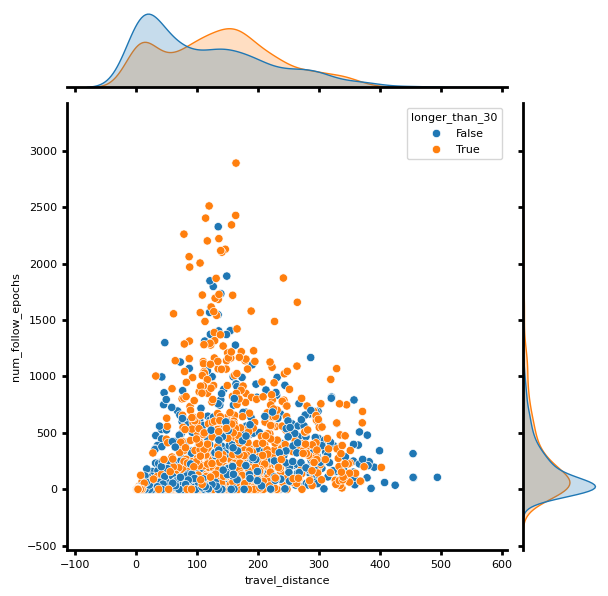

In [91]:
sns.jointplot(data=all_evaluation, x="travel_distance", y="num_follow_epochs", hue="longer_than_30")
#sns.jointplot(data=all_evaluation, x="travel_distance", y="no_food_hour")
plt.show()

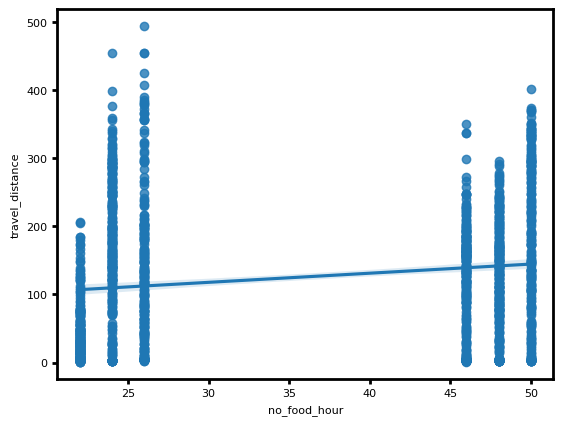

In [82]:
sns.regplot(data=all_evaluation, x='no_food_hour', y='travel_distance')
plt.show()